
# Introduction to Quantitative Biology — Lecture 1 Notebook

This notebook accompanies Lecture 1.
- Compare modelling views (deterministic / stochastic / probabilistic)
- Work through **protein partitioning at cell division**
- Verify $\mathbb{E}[(I_1-I_2)^2]=\alpha I_{\mathrm{tot}}$


## 0) Setup

In [13]:
# --- Basic scientific Python imports ---
import numpy as np
import matplotlib.pyplot as plt


# --- Randomness & reproducibility ---
# `rng` = a NumPy random number *generator* we’ll pass around explicitly.
# Why this pattern?
# - Reproducibility: setting a fixed seed makes stochastic results repeatable.
# - Control: by passing `rng` into functions, *all* randomness is centralized.
# - Modern API: `np.random.default_rng` is the recommended interface (vs legacy np.random.*).
#
# Change the seed below to get a different (but still reproducible) random stream.
# Set seed=None to get fresh randomness on each run.
rng = np.random.default_rng(seed=42)

# Quick sanity check (optional): draw a few random numbers
print(rng.integers(0, 10, size=5))

[0 7 6 4 4]



## Protein partitioning (Phillips, Ch. 2, pp. 43–48)


## Protein partitioning at cell division (coin flips → binomial)

**Setup.** A mother cell has `N` proteins.  
At division, each protein independently chooses daughter 1 with probability `p=0.5`
(otherwise it goes to daughter 2).

- Number in daughter 1: `n1 ~ Binomial(N, 0.5)`
- Number in daughter 2: `n2 = N - n1`

**Fluorescence calibration.** If each protein contributes intensity `alpha`, then:
``I1 = alpha * n1``, ``I2 = alpha * (N - n1)``, ``Itot = alpha * N``.

**Prediction to verify:**  
$$
\mathbb{E}\big[(I_1 - I_2)^2\big] \;=\; \alpha\, I_{\mathrm{tot}}.
$$

In [14]:
# --- Parameters you can play with ---
alpha = 1.0       # intensity contributed by each molecule
N_demo = 100      # we'll start by looking at a fixed N for intuition
reps_demo = 5000  # number of simulated divisions for the histogram

# We reuse the `rng` (random number generator) defined earlier for reproducibility.
# If you skipped that cell, uncomment the next line:
# rng = np.random.default_rng(seed=42)

print(f"alpha={alpha}, N_demo={N_demo}, reps_demo={reps_demo}")

alpha=1.0, N_demo=100, reps_demo=5000


In [15]:
def simulate_partition_once(N, alpha=1.0, rng=None):
    """
    Simulate a single mother cell division with N molecules.
    Each molecule independently goes to daughter 1 with probability 0.5.
    Returns a tuple: (n1, n2, I1, I2, Itot)
    """
    # 1) choose RNG
    if rng is None:
        rng = np.random.default_rng()
    
    # 2) sample n1 from Binomial(N, 0.5)
    n1 = rng.binomial(n=N, p=0.5)
    
    # 3) compute daughter 2 count
    n2 = N - n1
    
    # 4) map counts → intensities using the calibration alpha
    I1 = alpha * n1
    I2 = alpha * n2
    Itot = alpha * N
    
    return n1, n2, I1, I2, Itot

# Quick sanity check on a single run:
print(simulate_partition_once(10, alpha=1.0, rng=rng))

(6, 4, 6.0, 4.0, 10.0)


### Distribution of `n1` (fixed `N`)

First, let’s build intuition: if `N=100`, what does the distribution of `n1` look like?
We simulate many independent divisions and plot a histogram of the `n1` values.

This should look **binomial**, centered near `N/2`.

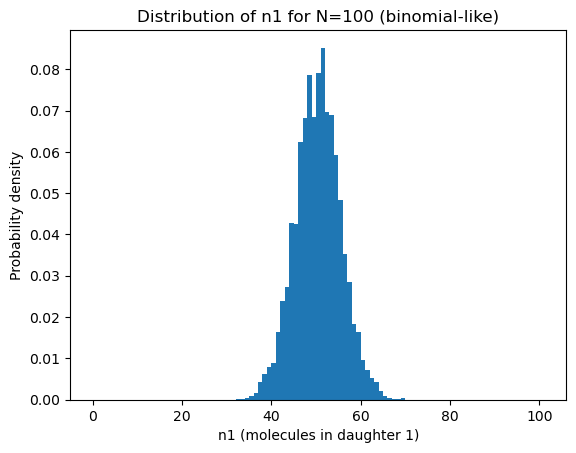

In [16]:
# Simulate many times for a fixed N to see the shape of n1
n1_samples = [simulate_partition_once(N_demo, alpha=alpha, rng=rng)[0]
              for _ in range(reps_demo)]

# Plot histogram (single plot, default style/colors)
plt.figure()
plt.hist(n1_samples, bins=range(0, N_demo+2), density=True)
plt.xlabel("n1 (molecules in daughter 1)")
plt.ylabel("Probability density")
plt.title(f"Distribution of n1 for N={N_demo} (binomial-like)")
plt.show()

### From molecule counts to intensities

Given the calibration `alpha`, we have:
- `I1 = alpha * n1`
- `I2 = alpha * (N - n1)`
- `Itot = alpha * N` (is constant for fixed `N`)

We will now verify the prediction:
$$
\mathbb{E}\big[(I_1 - I_2)^2\big] \;=\; \alpha\, I_{\mathrm{tot}}.
$$
We’ll do this empirically by simulating many divisions for many values of `N`.

In [19]:
# Choose a range of N to explore; feel free to tweak this list
N_values = [10, 20, 50, 100, 200, 500, 1000]

# For each N, simulate several divisions and store (Itot, (I1-I2)^2) pairs
Itot_list = []
diff_sq_list = []

reps_per_N = 300  # number of divisions to simulate for each N

for N in N_values:
    for _ in range(reps_per_N):
        n1, n2, I1, I2, Itot = simulate_partition_once(N, alpha=alpha, rng=rng)
        Itot_list.append(Itot)
        diff_sq_list.append((I1 - I2)**2)

# Convert to NumPy arrays for easy plotting/math
Itot_arr = np.array(Itot_list, dtype=float)
diff_sq_arr = np.array(diff_sq_list, dtype=float)

print(f"Generated {Itot_arr.size} simulated divisions "
      f"across {len(N_values)} N values.")

Generated 2100 simulated divisions across 7 N values.


### Visual check: cloud vs. linear prediction

We plot:
- x-axis: `I_tot`
- y-axis: `(I1 - I2)^2` for each simulated division
and overlay the **theoretical mean line**:
\[
y = \alpha \, x.
\]
If the theory is right, the cloud’s *average* at a given `I_tot` should follow this line.

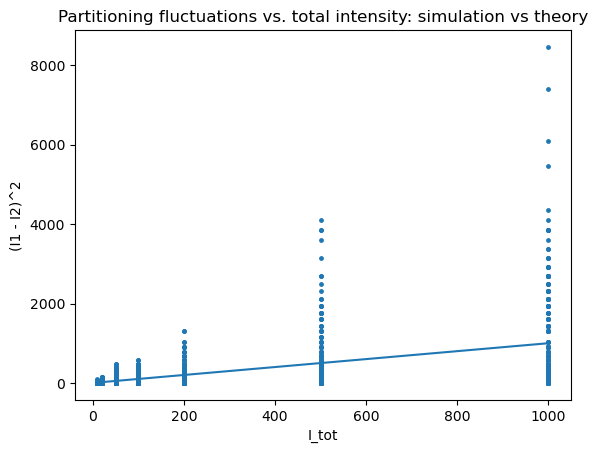

In [6]:
plt.figure()
plt.scatter(Itot_arr, diff_sq_arr, s=6)  # single plot; default styling

# Theoretical mean line: y = alpha * x
x_line = np.linspace(Itot_arr.min(), Itot_arr.max(), 200)
y_line = alpha * x_line
plt.plot(x_line, y_line)  # default line

plt.xlabel("I_tot")
plt.ylabel("(I1 - I2)^2")
plt.title("Partitioning fluctuations vs. total intensity: simulation vs theory")
plt.show()

### Optional (quick averaging to reveal the mean)

To make the “mean trend” more visible, we can **bin** the x-axis (`I_tot`)
and compute the average of `(I1 - I2)^2` in each bin.
This is not required, but helps visually confirm the linear relation.

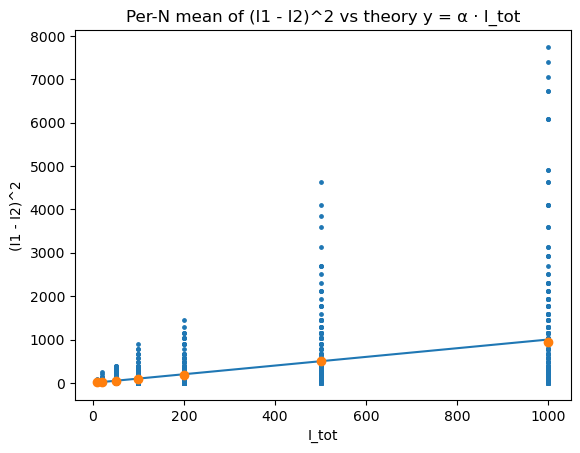

In [20]:
# --- Simple per-N averaging (no binning) ---

# 1) Raw cloud (already computed earlier as Itot_arr, diff_sq_arr)
plt.figure()
plt.scatter(Itot_arr, diff_sq_arr, s=6)  # raw points

# 2) Theory mean line: y = alpha * x
x_line = np.linspace(Itot_arr.min(), Itot_arr.max(), 200)
plt.plot(x_line, alpha * x_line)  # default style

# 3) Compute mean (I1 - I2)^2 for each N (i.e., each Itot = alpha * N)
unique_N = np.array(sorted(set(N_values)))
Itot_means = alpha * unique_N
mean_diff_per_N = []

for N in unique_N:
    mask = (Itot_arr == alpha * N)
    mean_diff_per_N.append(diff_sq_arr[mask].mean())

mean_diff_per_N = np.array(mean_diff_per_N)

# 4) Overlay the per-N averages (one marker per N)
plt.plot(Itot_means, mean_diff_per_N, marker="o",linestyle="none")  # default styling

plt.xlabel("I_tot")
plt.ylabel("(I1 - I2)^2")
plt.title("Per-N mean of (I1 - I2)^2 vs theory y = α · I_tot")
plt.show()

In [21]:
# Choose a range of N to explore; feel free to tweak this list
N_values = range(0,10000, 100)

# For each N, simulate several divisions and store (Itot, (I1-I2)^2) pairs
Itot_list = []
diff_sq_list = []

reps_per_N = 300  # number of divisions to simulate for each N

for N in N_values:
    for _ in range(reps_per_N):
        n1, n2, I1, I2, Itot = simulate_partition_once(N, alpha=alpha, rng=rng)
        Itot_list.append(Itot)
        diff_sq_list.append((I1 - I2)**2)

# Convert to NumPy arrays for easy plotting/math
Itot_arr = np.array(Itot_list, dtype=float)
diff_sq_arr = np.array(diff_sq_list, dtype=float)

print(f"Generated {Itot_arr.size} simulated divisions "
      f"across {len(N_values)} N values.")

Generated 30000 simulated divisions across 100 N values.


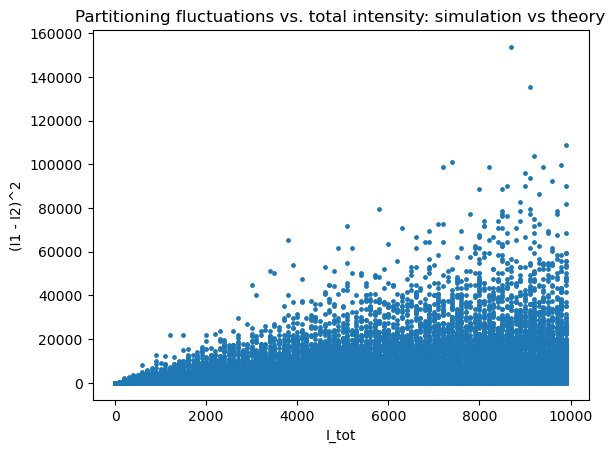

In [23]:
plt.figure()
plt.scatter(Itot_arr, diff_sq_arr, s=6)  # single plot; default styling

# Theoretical mean line: y = alpha * x
x_line = np.linspace(Itot_arr.min(), Itot_arr.max(), 200)
y_line = alpha * x_line
plt.plot(x_line, y_line)  # default line

plt.xlabel("I_tot")
plt.ylabel("(I1 - I2)^2")
plt.title("Partitioning fluctuations vs. total intensity: simulation vs theory")
plt.show()

### Optional (quick averaging to reveal the mean)

To make the “mean trend” more visible, we can **bin** the x-axis (`I_tot`)
and compute the average of `(I1 - I2)^2` in each bin.
This is not required, but helps visually confirm the linear relation.

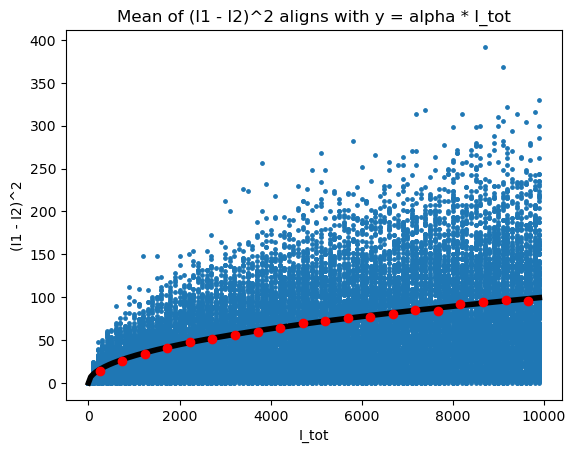

In [24]:
# We'll bin I_tot and compute the mean of (I1 - I2)^2 in each bin
num_bins = 20
bins = np.linspace(Itot_arr.min(), Itot_arr.max(), num_bins + 1)

bin_centers = []
bin_means = []

for i in range(num_bins):
    left, right = bins[i], bins[i+1]
    mask = (Itot_arr >= left) & (Itot_arr < right)
    if np.any(mask):
        bin_centers.append(0.5*(left+right))
        bin_means.append(diff_sq_arr[mask].mean())

bin_centers = np.array(bin_centers)
bin_means = np.array(bin_means)

plt.figure()
plt.scatter(Itot_arr, np.sqrt(diff_sq_arr), s=6)              # raw cloud
plt.plot(x_line, np.sqrt(y_line), 'k', linewidth=4)                             # theory mean line
plt.plot(bin_centers, np.sqrt(bin_means), 'r', marker="o", linewidth=0)         # binned averages (default style)
plt.xlabel("I_tot")
plt.ylabel("(I1 - I2)^2")
plt.title("Mean of (I1 - I2)^2 aligns with y = alpha * I_tot")
plt.show()